## CPOL Rainfall Radar Data and some Machine Learning Algorithms
This notebook applies a bunch of Marchine Learning algorithms, like Support Vector Machine classification, to get some insights about the CPOL radar (extreme) rainfall dataset.

In [131]:
%matplotlib inline
import pandas as pd
import numpy as np
from netCDF4 import Dataset as nc, num2date
import os
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime

Define the path's where data is storde

In [132]:
largeScaleFile = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_large-scale_forcing.hdf5')
largeScaleNc = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_large-scale_forcing.nc')
CPOL = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_area_avg_precip.pkl')

#### Load the datasets for CPOL rainfall and Large-scale forcing


In [133]:
cpolFrame = pd.HDFStore(largeScaleFile,'a')
plev = cpolFrame['T'].keys()
T = cpolFrame['T'].values[:]-273.15
r = cpolFrame['q'].values[:]/1000.

Calculate saturation specific hum. ($E_s$) from temperature and specific hum. ($q$) from mixing ratio ($r$)
and calculate saturation fraction rs = $int$ q / $int$ qs

In [134]:
a = 6.112 #hPa 
b, c = 17.62, 243.12 #C
d = 0.622
Es = a * np.exp(b * T / (c + T))
q = d * r / (a + r) * 10
#plev.v - 0.378 * Es.values
#qs= d * Es / (plev - 0.378 * Es)
#rs = pd.Series(q.sum(axis = -1) / qs.sum(axis = -1),index=times)

#### Define extreme events (9th decile)

In [135]:

data = cpolFrame

In [136]:
event = pd.Series(np.zeros(len(data['prec_srf'])),index = data['prec_srf'].index)
event.loc[data['prec_srf']['sfc'] > data['prec_srf']['sfc'].quantile(90/100.)] = 1.
#event.loc[data['CPOL_rain'] > data['CPOL_rain'].quantile(95/100.)] = 2.
event = pd.DataFrame(event,columns=['sfc'])
data.put('Event',event)

#### Define the variables of interest

In [137]:
values=['omega','q','Event']
level = [615,865,'sfc']
var = []
D={}
for l,v in enumerate(values):
    D[v] = data[v][level[l]].values
    idx = data[v].index
    if v != 'Event':
        var.append(v)

D=pd.DataFrame(D, index=idx)
idx = D.loc[D['omega']>1000].index
D.loc[idx] = np.nan
D = D.dropna()

#### Plot the data

In [138]:
idx = D['Event'] == 1
idx2 = D['Event'] == 0
D
bla = D[var]
scatter = [go.Scatter(
    x=bla.loc[idx][var[0]].values,
    y=bla.loc[idx][var[1]].values,
    #z=data.loc[idx][var[2]].values,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter(
    x=bla.loc[idx2][var[0]].values,
    y=bla.loc[idx2][var[1]].values,
    #z=data.loc[idx2][var[2]].values,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
          ]
idx = D['Event'] == 1
idx2 = D['Event'] == 0
bla = D[var].dropna()
scatter = [go.Scatter(
    x=bla.loc[idx][var[0]].values,
    y=bla.loc[idx][var[1]].values,
    #z=data.loc[idx][var[2]].values,
    mode='markers', 
    name = '>=9th decile',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter(
    x=bla.loc[idx2][var[0]].values,
    y=bla.loc[idx2][var[1]].values,
    #z=data.loc[idx2][var[2]].values,
    mode='markers',
    name='<9th decile',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
          ]
layout = go.Layout(xaxis=dict(title="Vertical Motion"), yaxis=dict(title='Humidity'))
py.iplot({'data': scatter, 'layout': layout}, filename='2d_scatter')

Extreme Events seem to occur in large-scale ascending environments, the humidity is also increased. Let's see if extreme events can be predicted from the two pre-cursers

#### Pre-Process the data
Data pre-processing is important. Here we split the data into test and training set und normalize the data

In [139]:
from sklearn.cross_validation import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy')

#lda = LDA(n_components=3)
y = D['Event'].values
X = D[var].values
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Define a plotting function for visualitation

In [140]:
def plot_classifier(X_set, y_set, classifier, xlabel=None, ylabel=None, title=None):
    label = {1:'Yes', 0:'No'}
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green'))(i), label = label[i] )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)# Visualising the Test set results
    plt.legend()

### First try Support vector machine
First try a kernel support vector classifier (SVC) algorithm 

In [141]:
classifier = SVC(C=1, kernel = 'rbf', degree = 5 ,gamma='auto')
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
label = {1:'Extreme-Event', 0:'No-Extreme-Event'}
cm

array([[1616,   11],
       [  68,  119]])

The miss-rate (68) in the confusion matrix is to high

#### Plot the result

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.



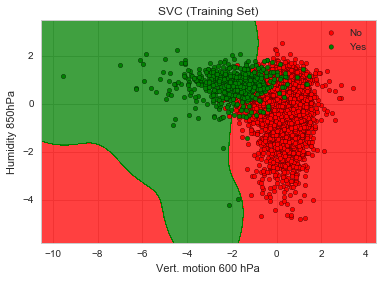

In [142]:
plot_classifier(X_train, y_train, classifier, xlabel='Vert. motion 600 hPa', ylabel='Humidity 850hPa', 
                title='SVC (Training Set)')

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.



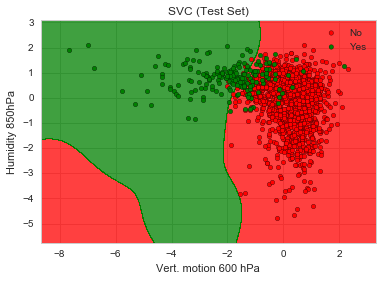

In [143]:
plot_classifier(X_test, y_test, classifier, xlabel='Vert. motion 600 hPa', ylabel='Humidity 850hPa',
                title='SVC (Test Set)')

### Try Random Forst
Now try a random-forest classifier

In [144]:
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0)
#classifier = LR(tol = 0.01)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm #Confusion Matrix

array([[1598,   29],
       [  67,  120]])

The miss-rate (67) is still too high

#### Visualize the results

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.

/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning:

In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.



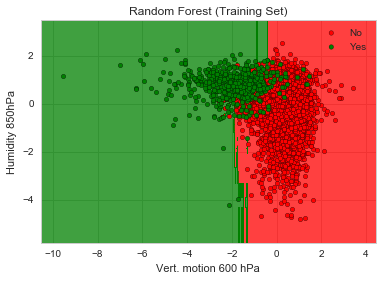

In [145]:
plot_classifier(X_train, y_train, classifier, xlabel='Vert. motion 600 hPa', ylabel='Humidity 850hPa', 
                title='Random Forest (Training Set)')

The result looks bettern than for the SVC but we still have a lot of misses

In [ ]:
plot_classifier(X_test, y_test, classifier, xlabel='Vert. motion 600 hPa', ylabel='Humidity 850hPa', 
                title='Random Forest (Test Set)')




### Now do some cluster analysis

In [ ]:
import scipy.cluster.hierarchy as sch
E = D[var]
dendrogram = sch.dendrogram(sch.linkage(E.values, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Event Types')
plt.ylabel('Euclidean distances')
plt.show()

The dendrogram suggests that two clusters might be the best (Extreme-events , Non-Extreme events)
we could have also guessed that

In [ ]:
# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')

In [ ]:
y_pred = hc.fit_predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm #Confusion Matrix

In [ ]:
d = pd.DataFrame(X_test,columns=var)
d['Cluster']=pd.Series(y_pred+1)

In [ ]:
c1 = d['Cluster'] == 1
c2 = d['Cluster'] == 2
#c3 = E['Cluster'] == 3

bla = d[var]
scatter = [go.Scatter(
    x=bla.loc[c1][var[0]].values,
    y=bla.loc[c1][var[1]].values,
    #z=bla.loc[c1][var[2]].values,
    name='Cluster #1',
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
),
go.Scatter(
    x=bla.loc[c2][var[0]].values,
    y=bla.loc[c2][var[1]].values,
    #z=bla.loc[c2][var[2]].values,
    name='Cluster #2',
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='red',
            width=0.5
        ),
        opacity=0.8
    )
),
#go.Scatter(
#    x=bla.loc[c3][var[0]].values,
#    y=bla.loc[c3][var[1]].values,
    #z=bla.loc[c3][var[2]].values,
#    name='Cluster #3',
#    mode='markers',
#    marker=dict(
#        size=4,
#        line=dict(
#            color='green',
#            width=0.5
#        ),
#        opacity=0.8
#    )
#),
           
          ]
layout = go.Layout(xaxis=dict(title="Vertical Motion"), yaxis=dict(title='Humidity'))
#layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0),scene=go.Scene(xaxis=go.XAxis(title="Vert. Motion"),
#    yaxis=go.YAxis(title='Humidity')))#,zaxis=go.ZAxis(title='d(s)/dt')))
py.iplot({'data': scatter, 'layout': layout}, filename='3d_scatter-cluster')

In [ ]:
# 